# Notebook for alignment analysis

Imports

In [1]:
import time
import os
import importlib

from pprint import pprint
from collections import defaultdict
from pathlib import Path
from more_itertools import grouper
from itertools import islice, chain, zip_longest, repeat

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.axes as ax
import seaborn as sns

import scipy
from scipy import io
from scipy.signal import convolve
from scipy.sparse import coo_matrix, csr_matrix
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import cut_tree

from statsmodels.stats import multitest

from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

import pyBigWig
import pysam
import re

from Modules import utils, plot_utils

Useful global variables

In [2]:
importlib.reload(utils)
importlib.reload(plot_utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Name of chromosomes in GRCh38 and T2T-CHM13v2.0
Header for BigWig files, with chromosome lengths

In [3]:
hg38_chr_ids = {
    1: 'NC_000001.11',
    2: 'NC_000002.12',
    3: 'NC_000003.12',
    4: 'NC_000004.12',
    5: 'NC_000005.10',
    6: 'NC_000006.12',
    7: 'NC_000007.14',
    8: 'NC_000008.11',
    9: 'NC_000009.12',
    10: 'NC_000010.11',
    11: 'NC_000011.10',
    12: 'NC_000012.12',
    13: 'NC_000013.11',
    14: 'NC_000014.9',
    15: 'NC_000015.10',
    16: 'NC_000016.10',
    17: 'NC_000017.11',
    18: 'NC_000018.10',
    19: 'NC_000019.10',
    20: 'NC_000020.11',
    21: 'NC_000021.9',
    22: 'NC_000022.11',
    'X': 'NC_000023.11',
    'Y': 'NC_000024.10',}
T2T_chr_ids = {
    1: 'NC_060925.1',
    2: 'NC_060926.1',
    3: 'NC_060927.1',
    4: 'NC_060928.1',
    5: 'NC_060929.1',
    6: 'NC_060930.1',
    7: 'NC_060931.1',
    8: 'NC_060932.1',
    9: 'NC_060933.1',
    10: 'NC_060934.1',
    11: 'NC_060935.1',
    12: 'NC_060936.1',
    13: 'NC_060937.1',
    14: 'NC_060938.1',
    15: 'NC_060939.1',
    16: 'NC_060940.1',
    17: 'NC_060941.1',
    18: 'NC_060942.1',
    19: 'NC_060943.1',
    20: 'NC_060944.1',
    21: 'NC_060945.1',
    22: 'NC_060946.1',
    'X': 'NC_060947.1',
    'Y': 'NC_060948.1',}
GRCh38_header = [
    ("chr1", 248956422),
    ("chr2", 242193529),
    ("chr3", 198295559),
    ("chr4", 190214555),
    ("chr5", 181538259),
    ("chr6", 170805979),
    ("chr7", 159345973),
    ("chr8", 145138636),
    ("chr9", 138394717),
    ("chr10", 133797422),
    ("chr11", 135086622),
    ("chr12", 133275309),
    ("chr13", 114364328),
    ("chr14", 107043718),
    ("chr15", 101991189),
    ("chr16", 90338345),
    ("chr17", 83257441),
    ("chr18", 80373285),
    ("chr19", 58617616),
    ("chr20", 64444167),
    ("chr21", 46709983),
    ("chr22", 50818468),
    ("chrX", 156040895),
    ("chrY", 57227415),]
GRCh38_lengths = dict(GRCh38_header)
T2T_header = [
    ("chr1", 248387328),
    ("chr2", 242696752),
    ("chr3", 201105948),
    ("chr4", 193574945),
    ("chr5", 182045439),
    ("chr6", 172126628),
    ("chr7", 160567428),
    ("chr8", 146259331),
    ("chr9", 150617247),
    ("chr10", 134758134),
    ("chr11", 135127769),
    ("chr12", 133324548),
    ("chr13", 113566686),
    ("chr14", 101161492),
    ("chr15", 99753195),
    ("chr16", 96330374),
    ("chr17", 84276897),
    ("chr18", 80542538),
    ("chr19", 61707364),
    ("chr20", 66210255),
    ("chr21", 45090682),
    ("chr22", 51324926),
    ("chrX", 154259566),
    ("chrY", 62460029),]
T2T_lengths = dict(T2T_header)
# {"NC_060925.1":"1", "NC_060926.1":"2", "NC_060927.1":"3", "NC_060928.1":"4", "NC_060929.1":"5", "NC_060930.1":"6", "NC_060931.1":"7", "NC_060932.1":"8", "NC_060933.1":"9", "NC_060934.1":"10", "NC_060935.1":"11", "NC_060936.1":"12", "NC_060937.1":"13", "NC_060938.1":"14", "NC_060939.1":"15", "NC_060940.1":"16", "NC_060941.1":"17", "NC_060942.1":"18", "NC_060943.1":"19", "NC_060944.1":"20", "NC_060945.1":"21", "NC_060946.1":"22", "NC_060947.1":"X", "NC_060948.1":"Y"}

Parse sam files and save in npz format (deprecated)

In [ ]:
data = 'Judith-H3K27me3'
# ip_coord = utils.parse_sam(Path(data_dir, data, 'raw_data', 'IP', D1145C41_trimmed_paired.sam'))
# ctrl_coord = utils.parse_sam(Path(data_dir, data, 'raw_data, 'Control, 'D1145C46_trimmed_paired.sam'))

# if not Path(data_dir, data, 'results', f'{data}_IP_coord_all_chr.npz').is_file():
#     np.savez_compressed(Path(data_dir, data, 'results', f'{data}_IP_coord_all_chr'),
#                         **ip_coord)
# if not Path(data_dir, data, 'results', f'{data}_Control_coord_all_chr.npz').is_file():
#     np.savez_compressed(Path(data_dir, data, 'results', f'{data}_Control_coord_all_chr'),
#                         **ctrl_coord)

54717931/105167322 paired reads rejected


Parse bam files and save in npz format

In [5]:
data = 'CTCF'
genome = 'T2T-CHM13v2.0'
# div = 8
ip_coord = utils.parse_bam(Path(data_dir, data, 'results', 'alignments', genome, 'IP_paired_T2T.sorted.bam'))
ctrl_coord = utils.parse_bam(Path(data_dir, data, 'results', 'alignments', genome, 'Control_paired_T2T.sorted.bam'))
ip_npz_file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_IP_coord_all_chr.npz')
ctrl_npz_file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_Control_coord_all_chr.npz')
if not ip_npz_file.is_file():
    np.savez_compressed(ip_npz_file, **ip_coord)
if not ctrl_npz_file.is_file():
    np.savez_compressed(ctrl_npz_file, **ctrl_coord)


0/13154074 reads rejected
0/24641372 reads rejected


Parse single-end bam files and save in npz format

In [23]:
data = 'H3K9me3-GSE175752' 
genome = 'T2T-CHM13v2.0'
for i in range(30, 38):
    ip_access = f'SRR146783{i+8}'
    ctrl_access = f'SRR146783{i}'
    ip_coord = utils.parse_bam(Path(data_dir, data, 'results', 'alignments', genome, f'{ip_access}_T2T.sorted.bam'), paired=False, fragment_length=250)
    ctrl_coord = utils.parse_bam(Path(data_dir, data, 'results', 'alignments', genome, f'{ctrl_access}_T2T.sorted.bam'), paired=False, fragment_length=250)
    ip_npz_file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{ip_access}_{genome}_IP_coord_all_chr.npz')
    ctrl_npz_file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{ctrl_access}_{genome}_Control_coord_all_chr.npz')
    if not ip_npz_file.is_file():
        np.savez_compressed(ip_npz_file, **ip_coord)
    if not ctrl_npz_file.is_file():
        np.savez_compressed(ctrl_npz_file, **ctrl_coord)

0/29657910 paired reads rejected
0/25426870 paired reads rejected
0/26175159 paired reads rejected
0/21063530 paired reads rejected
0/22606816 paired reads rejected
0/25035217 paired reads rejected
0/28199410 paired reads rejected
0/21901600 paired reads rejected
0/26626674 paired reads rejected
0/27302126 paired reads rejected
0/34406481 paired reads rejected
0/32337947 paired reads rejected
0/23176481 paired reads rejected
0/30195088 paired reads rejected
0/44731176 paired reads rejected
0/34051616 paired reads rejected


Full genome analysis

In [58]:
importlib.reload(utils)
data = 'CTCF'
genome = 'T2T-CHM13v2.0'
maxfragment = 500
binsize = 50

if genome == 'T2T-CHM13v2.0':
    chr_lens = T2T_lengths
    chr_ids = T2T_chr_ids
elif genome == 'GRCh38':
    chr_lens = GRCh38_lengths
    chr_ids = hg38_chr_ids

binned_chr_lens = np.array([x // binsize + 1 for x in chr_lens.values()])
chr_seps = np.cumsum(binned_chr_lens)
total_length = chr_seps[-1]

log_file = Path(data_dir, data, 'results', 'alignments', genome, 'alignment_analysis_log.txt')
log_file = utils.safe_filename(log_file)
with open(log_file, 'w') as f:
    f.write(f'data: {data}\n'
            f'genome: {genome}\n'
            f'max fragment length: {maxfragment}\n'
            f'bin size: {binsize}\n\n')
ip_lengths = []
ctrl_lengths = []
columns = ['pos', 'ip_count', 'ctrl_count', 'pval', 'qval']
df = pd.DataFrame(np.zeros((total_length, len(columns))), columns=columns)
for i, chr_id in enumerate(chr_ids.keys()):
    chr_len = chr_lens[f'chr{chr_id}']
    print(f"processing chr{chr_id}...")
    # Load chromosome
    with np.load(Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_IP_coord_all_chr.npz')) as f:
        ip_coord_chr = f[chr_ids[chr_id]]
    with np.load(Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_Control_coord_all_chr.npz')) as f:
        ctrl_coord_chr = f[chr_ids[chr_id]]
    # Filter out fragments too long
    ip_lengths_chr = np.diff(ip_coord_chr, axis=1).ravel()
    ctrl_lengths_chr = np.diff(ctrl_coord_chr, axis=1).ravel()
    ip_lengths.append(ip_lengths_chr)
    ctrl_lengths.append(ctrl_lengths_chr)
    ip_coord_chr = ip_coord_chr[ip_lengths_chr <= maxfragment, :]
    ctrl_coord_chr = ctrl_coord_chr[ctrl_lengths_chr <= maxfragment, :]
    # Get binned middle alignment
    ip_count_chr = utils.binned_alignment_count_from_coord(ip_coord_chr, binsize=binsize, length=chr_len)
    ctrl_count_chr = utils.binned_alignment_count_from_coord(ctrl_coord_chr, binsize=binsize, length=chr_len)
    
    df.iloc[chr_seps[i]-len(ip_count_chr):chr_seps[i], :3] = np.transpose(np.vstack((
        np.arange(0, len(ip_count_chr)*binsize, binsize),
        ip_count_chr,
        ctrl_count_chr
    )))
    # Write log info
    with open(log_file, 'a') as f:
        f.write(f'Processing chr{chr_id}...\n'
                f'{np.sum(ip_lengths_chr >= maxfragment)} fragments longer than {maxfragment}bp in IP\n'
                f'{np.sum(ctrl_lengths_chr >= maxfragment)} fragments longer than {maxfragment}bp in Control\n')
    # Make dataframe and save
    csv_name = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_maxfragment_{maxfragment}_binsize_{binsize}.csv')
    csv_name = utils.safe_filename(csv_name)
    df.to_csv(csv_name)
ip_lengths = np.concatenate(tuple(ip_lengths))
ctrl_lengths = np.concatenate(tuple(ctrl_lengths))

processing chr1...
processing chr2...
processing chr3...
processing chr4...
processing chr5...
processing chr6...
processing chr7...
processing chr8...
processing chr9...
processing chr10...
processing chr11...
processing chr12...
processing chr13...
processing chr14...
processing chr15...
processing chr16...
processing chr17...
processing chr18...
processing chr19...
processing chr20...
processing chr21...
processing chr22...
processing chrX...
processing chrY...


Full genome analysis on multiple files

In [108]:
data = 'H3K9me3-GSE175752'
genome = 'T2T-CHM13v2.0'
threshold = 500
bins = 50000

if genome == 'T2T-CHM13v2.0':
    lengths = T2T_lengths
    chr_ids = T2T_chr_ids
elif genome == 'GRCh38':
    lengths = GRCh38_lengths
    chr_ids = hg38_chr_ids
log_file = Path(data_dir, data, 'results', 'alignments', genome, 'alignment_analysis_log.txt')
log_file = utils.safe_filename(log_file)
with open(log_file, 'w') as f:
    f.write(f'data: {data}\n'
            f'genome: {genome}\n'
            f'length threshold: {threshold}\n'
            f'bins: {bins}\n\n')
for i in range(30, 38):
    ip_access = f'SRR146783{i+8}'
    ctrl_access = f'SRR146783{i}'
    with open(log_file, 'w') as f:
        f.write(f'\nProcessing {ctrl_access}-{ip_access}\n')
    print(f"Processing {ctrl_access}-{ip_access}")
    for chr_id in chr_ids.keys():
        # Load chromosome
        with np.load(Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{ip_access}_{genome}_IP_coord_all_chr.npz')) as f:
            ip_coord_chr = f[chr_ids[chr_id]]
        with np.load(Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{ctrl_access}_{genome}_Control_coord_all_chr.npz')) as f:
            ctrl_coord_chr = f[chr_ids[chr_id]]
        # Get binned middle alignment
        ip_binned_signal_chr = utils.binned_alignment_signal_from_coord(ip_coord_chr, bins=bins, length=lengths[f'chr{chr_id}'])
        ctrl_binned_signal_chr = utils.binned_alignment_signal_from_coord(ctrl_coord_chr, bins=bins, length=lengths[f'chr{chr_id}'])
        # Get processed signals
        log_ratio_chr = np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
        KL_chr = ip_binned_signal_chr * np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
        p_binom = len(ip_coord_chr) / (len(ip_coord_chr) + len(ctrl_coord_chr))
        n_binom = ip_binned_signal_chr + ctrl_binned_signal_chr
        p_vals = 1 - scipy.stats.binom.cdf(ip_binned_signal_chr - 1, n_binom, p_binom)
        # Correct p_values
        reject, q_vals, _, _ = multitest.multipletests(p_vals, method='fdr_bh')
        # Write log info
        with open(log_file, 'a') as f:
            f.write(f'Processing chr{chr_id}...\n'
                    f'{np.sum(reject)}/{len(reject)} significant bins\n')
        # Make dataframe and save
        df = pd.DataFrame({'pos': np.arange(0, len(ip_binned_signal_chr)*bins, bins),
                        'ip_binned_signal': ip_binned_signal_chr,
                        'ctrl_binned_signal': ctrl_binned_signal_chr,
                        'log_ratio': log_ratio_chr,
                        'KL': KL_chr,
                        'binom_p_value': p_vals,
                        'binom_q_value': q_vals})
        csv_name = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{ip_access}_{genome}_chr{chr_id}_thres_{threshold}_binned_{bins}.csv')
        csv_name = utils.safe_filename(csv_name)
        df.to_csv(csv_name)

Processing SRR14678330-SRR14678338


/tmp/ipykernel_317723/3831584347.py:35: RuntimeWarning: divide by zero encountered in true_divide
  log_ratio_chr = np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_317723/3831584347.py:36: RuntimeWarning: divide by zero encountered in true_divide
  KL_chr = ip_binned_signal_chr * np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_317723/3831584347.py:35: RuntimeWarning: invalid value encountered in true_divide
  log_ratio_chr = np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_317723/3831584347.py:35: RuntimeWarning: divide by zero encountered in log10
  log_ratio_chr = np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_317723/3831584347.py:36: RuntimeWarning: invalid value encountered in true_divide
  KL_chr = ip_binned_signal_chr * np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_317723/3831584347.py:36: RuntimeWarning: divide by zero encountered in log10
  KL_chr = ip_binned_sig

Processing SRR14678331-SRR14678339
Processing SRR14678332-SRR14678340
Processing SRR14678333-SRR14678341
Processing SRR14678334-SRR14678342
Processing SRR14678335-SRR14678343
Processing SRR14678336-SRR14678344
Processing SRR14678337-SRR14678345


Plot fragment lengths

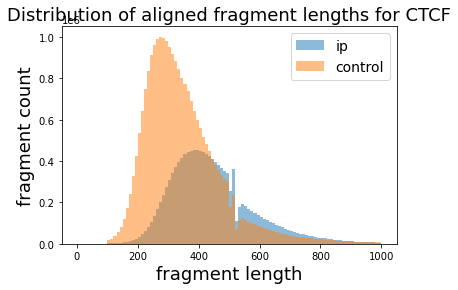

In [10]:
plt.hist(ip_lengths, bins=100, range=(0, 1000), label='ip', alpha=0.5)
plt.hist(ctrl_lengths, bins=100, range=(0, 1000), label='control', alpha=0.5)
plt.legend(fontsize=14)
plt.title(f'Distribution of aligned fragment lengths for {data}', fontsize=18)
plt.xlabel('fragment length', fontsize=18)
plt.ylabel('fragment count', fontsize=18)
fig_name = Path(data_dir, data, 'results', f'{data}_fragment_length_distribution.png')
fig_name = utils.safe_filename(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

Merging to a full genome, and computing p_value and q_value

In [4]:
genome = 'T2T-CHM13v2.0'
max_fragment_len = 500
bins = 50

# data = 'Judith-H3K4me3'
# full_genome_H3K4me3_1000, _ = utils.merging_full_genome(data, genome, max_fragment_len, bins, data_dir=data_dir)
# data = 'Judith-H3K9me3'
# full_genome_H3K9me3_1000, _ = utils.merging_full_genome(data, genome, max_fragment_len, bins, data_dir=data_dir)

data = 'CTCF'
full_genome_CTCF_50, seperators_50 = utils.merging_full_genome(data, genome, max_fragment_len, bins, data_dir=data_dir)

# data = 'H3K9me3-GSE175752'
# H3K9me3_Rechem = []
# for i in range(38, 46):
#     ip_access = f'SRR146783{i}'
#     df_merge, _ = merging_full_genome(data, genome, max_fragment_len, bins, access=ip_access)
#     H3K9me3_Rechem.append(df_merge)

120791/62345519 significantly enriched bins in CTCF downsampled by 1
118853/62345519 significantly enriched bins in CTCF when chromosome local


<AxesSubplot:title={'center':'Significant p-value distribution on CTCF with bin size 200 and full coverage'}, ylabel='Frequency'>

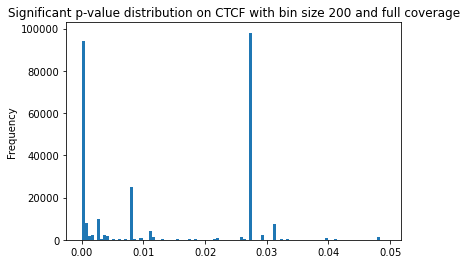

In [185]:
full_genome_CTCF_200['pvalue_divby1'][full_genome_CTCF_200['pvalue_divby1']<0.05].plot(
    kind='hist',
    bins=100,
    grid=False,
    xlabel='p-value',
    title='Significant p-value distribution on CTCF with bin size 200 and full coverage')

<AxesSubplot:title={'center':'Significant p-value distribution on CTCF with bin size 200 and full coverage'}, ylabel='Frequency'>

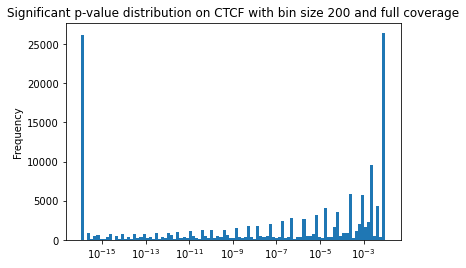

In [208]:
subdf = full_genome_CTCF_200['pvalue_divby1'][full_genome_CTCF_200['pvalue_divby1']<1e-2]
logbins = np.geomspace(subdf.min(), subdf.max(), 100)
subdf.plot(
    kind='hist',
    bins=logbins,
    grid=False,
    logx=True,
    xlabel='p-value',
    title='Significant p-value distribution on CTCF with bin size 200 and full coverage')

In [206]:
subdf = full_genome_CTCF_200[(full_genome_CTCF_200['pvalue_divby1']<1e-15)].loc[:, ['ip_binned_signal', 'ctrl_binned_signal', 'pvalue_divby1']]
print(len(subdf[subdf['ip_binned_signal'] >= 30]), len(subdf))
subdf

27750 28341


,ip_binned_signal,ctrl_binned_signal,pvalue_divby1
17,51.0,6.0,1.110223e-16
18,97.0,10.0,1.110223e-16
19,105.0,8.0,1.110223e-16
20,45.0,5.0,1.110223e-16
63,62.0,6.0,1.110223e-16
...,...,...,...
15274065,33.0,0.0,1.110223e-16
15274066,57.0,3.0,1.110223e-16
15586296,39.0,0.0,1.110223e-16
15586348,34.0,2.0,5.551115e-16


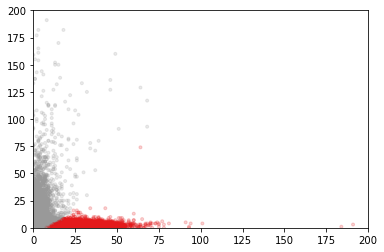

In [57]:
# Show significant enrichments based on ip and ctrl coverage
plt.scatter(full_genome_CTCF_50["ip_binned_signal"], full_genome_CTCF_50["ctrl_binned_signal"], c=full_genome_CTCF_50["significant_divby1"], label='positions', cmap=plt.cm.get_cmap('Set1_r'), marker='.', alpha=0.2)
plt.xlim(left=0, right=200)
plt.ylim(bottom=0, top=200)
plt.show()
plt.close()

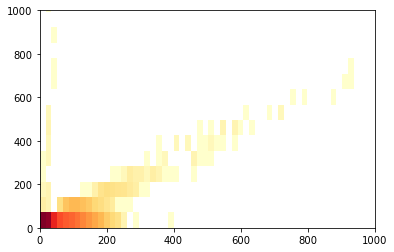

In [119]:
_, bin_edges_x = np.histogram(full_genome_H3K4me3_1000["ip_binned_signal"], bins=100)
_, bin_edges_y = np.histogram(full_genome_H3K4me3_1000["ctrl_binned_signal"], bins=100)
bin_edges = [bin_edges_x, bin_edges_y]
plt.hist2d(full_genome_H3K4me3_1000["ip_binned_signal"], full_genome_H3K4me3_1000["ctrl_binned_signal"], bins=bin_edges, density=True, norm=mpl.colors.LogNorm(), cmap=plt.cm.get_cmap('YlOrRd'))
plt.xlim(left=0, right=1000)
plt.ylim(bottom=0, top=1000)
plt.show()
plt.close()

In [15]:
def merging_full_genome(data,
                        genome,
                        max_fragment_len,
                        bins,
                        access='',
                        verbose=True,
                        data_dir='../shared_folder'):
    if genome == 'T2T-CHM13v2.0':
        lengths = T2T_lengths
        chr_ids = T2T_chr_ids
    elif genome == 'GRCh38':
        lengths = GRCh38_lengths
        chr_ids = hg38_chr_ids
    if access != '':
        access = '_' + access
    # merging chromosomes
    binned_lengths = np.array([x // bins + 1 for x in lengths.values()])
    seperators = np.cumsum(binned_lengths)
    total_length = seperators[-1]
    for i, chr_id in enumerate(chr_ids.keys()):
        df = pd.read_csv(
            Path(data_dir, data, 'results', 'alignments', genome,
                 f'{data}{access}_{genome}_chr{chr_id}_'
                 f'thres_{max_fragment_len}_binned_{bins}.csv'),
            index_col=0)
        if i == 0:
            full_genome = pd.DataFrame(
                np.zeros((total_length, len(df.columns))),
                columns=df.columns)
        full_genome.iloc[seperators[i]-len(df):seperators[i], :] = df
    return full_genome, seperators

In [32]:
data = 'CTCF'
bins = 50
full_genome_CTCF_50, seperators_50 = merging_full_genome(data, genome, max_fragment_len, bins, data_dir=data_dir)
full_genome_CTCF_50

,pos,ip_binned_signal,ctrl_binned_signal,log_ratio,KL,binom_p_value,binom_q_value
0,0.0,0.0,0.0,NaN,NaN,1.0,1.0
1,50.0,0.0,1.0,-inf,NaN,1.0,1.0
2,100.0,0.0,0.0,NaN,NaN,1.0,1.0
3,150.0,0.0,0.0,NaN,NaN,1.0,1.0
4,200.0,0.0,3.0,-inf,NaN,1.0,1.0
...,...,...,...,...,...,...,...
62345514,62459800.0,0.0,0.0,NaN,NaN,1.0,1.0
62345515,62459850.0,0.0,0.0,NaN,NaN,1.0,1.0
62345516,62459900.0,0.0,2.0,-inf,NaN,1.0,1.0
62345517,62459950.0,0.0,0.0,NaN,NaN,1.0,1.0


In [18]:
genome = 'T2T-CHM13v2.0'
max_fragment_len = 500
bins_list = [50000, 5000, 1000, 200, 50]
frac_list = np.linspace(0.01, 1, 100)
importlib.reload(utils)
# data = 'Judith-H3K4me3'
# H3K4me3_enrichments = utils.downsample_enrichment_analysis(data, genome, max_fragment_len, bins_list, div_list, reverse=True)
# data = 'Judith-H3K9me3'
# H3K9me3_enrichments = utils.downsample_enrichment_analysis(data, genome, max_fragment_len, bins_list, div_list, reverse=True)
data = 'CTCF'
CTCF_enrichments = utils.downsample_enrichment_analysis(data, genome, max_fragment_len, bins_list, frac_list=frac_list, reverse=True, use_fdr=False)
CTCF_enrichments

IP IP_clust Undetermined  Ctrl Ctrl_clust   total_cov
50000 0.01    2265     2155        58866  1228       1076      316415
      0.02    4621     4074        54279  3459       2763      632830
      0.03    6417     5420        50642  5300       3819      949244
      0.04    8095     6520        47678  6586       4378     1265659
      0.05    9521     7315        45028  7810       4843     1582074
...            ...      ...          ...   ...        ...         ...
50    0.96  326318   114934     62014507  4694       3481  30375826.0
      0.97  328906   115900     62011761  4852       3626  30692241.0
      0.98  331459   117074     62009130  4930       3689  31008655.0
      0.99  334081   118032     62006307  5131       3872  31325070.0
      1.00  336645   119245     62003613  5261       3978  31641485.0

[500 rows x 6 columns]

In [19]:
# H3K4me3_file = Path(data_dir, 'Judith-H3K4me3', 'results', 'alignments', genome, 'H3K4me3_downsample_enrichments.csv')
# if not H3K4me3_file.is_file():
#     H3K4me3_enrichments.to_csv(H3K4me3_file)
#     print('H3K4me3 saved')
# H3K9me3_file = Path(data_dir, 'Judith-H3K9me3', 'results', 'alignments', genome, 'H3K9me3_downsample_enrichments.csv')
# if not H3K9me3_file.is_file():
#     H3K9me3_enrichments.to_csv(H3K9me3_file)
#     print('H3K9me3 saved')
CTCF_file = Path(data_dir, 'CTCF', 'results', 'alignments', genome, 'CTCF_downsample_enrichments_v5_pval_fine_resolution.csv')
if not CTCF_file.is_file():
    CTCF_enrichments.to_csv(CTCF_file)
    print(f'{CTCF_file} saved')


../shared_folder/CTCF/results/alignments/T2T-CHM13v2.0/CTCF_downsample_enrichments_v5_pval_fine_resolution.csv saved


In [22]:
# H3K4me3_enrichments = pd.read_csv(Path(data_dir, 'Judith-H3K4me3', 'results', 'alignments', genome, 'H3K4me3_downsample_enrichments.csv'), index_col=[0, 1])
# H3K9me3_enrichments = pd.read_csv(Path(data_dir, 'Judith-H3K9me3', 'results', 'alignments', genome, 'H3K9me3_downsample_enrichments.csv'), index_col=[0, 1])
CTCF_enrichments_qval = pd.read_csv(Path(data_dir, 'CTCF', 'results', 'alignments', genome, 'CTCF_downsample_enrichments_v5_qval_fine_resolution.csv'), index_col=[0, 1])
CTCF_enrichments_pval = pd.read_csv(Path(data_dir, 'CTCF', 'results', 'alignments', genome, 'CTCF_downsample_enrichments_v5_pval_fine_resolution.csv'), index_col=[0, 1])

CTCF_enrichments_qval

IP  IP_clust  Undetermined  Ctrl  Ctrl_clust   total_cov
50000 0.01       2         2         62354     3           2    316415.0
      0.02      99        97         62256     4           3    632830.0
      0.03     576       560         61511   272         256    949244.0
      0.04    1322      1246         59952  1085         952   1265659.0
      0.05    2683      2463         57586  2090        1661   1582074.0
...            ...       ...           ...   ...         ...         ...
50    0.96  135474     42981      62209910   135          66  30375826.0
      0.97  136891     43155      62208492   136          68  30692241.0
      0.98  138280     43361      62207102   137          68  31008655.0
      0.99  139698     43541      62205673   148          75  31325070.0
      1.00  141158     43743      62204211   150          76  31641485.0

[500 rows x 6 columns]

In [27]:
# H3K4me3_enrichments['sig_perc'] = (H3K4me3_enrichments['IP'] + H3K4me3_enrichments['Ctrl']) / H3K4me3_enrichments[['IP', 'Undetermined', 'Ctrl']].sum(axis=1)
# H3K9me3_enrichments['sig_perc'] = (H3K9me3_enrichments['IP'] + H3K9me3_enrichments['Ctrl']) / H3K9me3_enrichments[['IP', 'Undetermined', 'Ctrl']].sum(axis=1)
CTCF_enrichments_pval['sig_perc'] = 100 * (CTCF_enrichments_pval['IP'] + CTCF_enrichments_pval['Ctrl']) / CTCF_enrichments_pval[['IP', 'Undetermined', 'Ctrl']].sum(axis=1)
CTCF_enrichments_pval['IP_perc'] = 100 * (CTCF_enrichments_pval['IP']) / CTCF_enrichments_pval[['IP', 'Undetermined', 'Ctrl']].sum(axis=1)

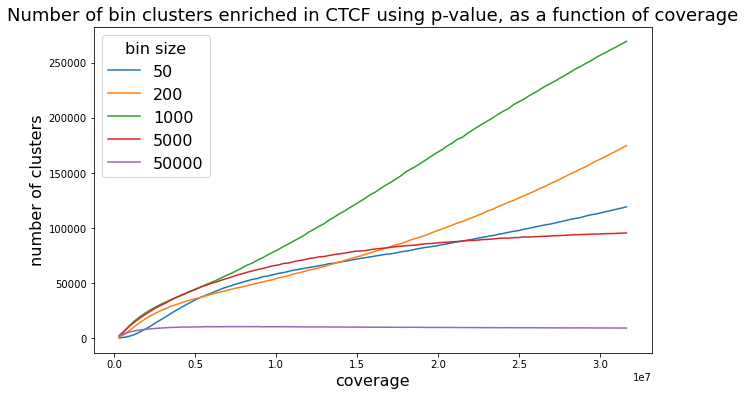

In [29]:
bins_list = list(CTCF_enrichments_pval.index.levels[0])
div_list = list(CTCF_enrichments_pval.index.levels[1])
plt.figure(figsize=(10, 6))
for b in bins_list:
    plt.plot(CTCF_enrichments_pval.loc[b, 'total_cov'], CTCF_enrichments_pval.loc[b, 'IP_clust'], label=b)
plt.legend(fontsize=16, title='bin size', title_fontsize=16)
plt.title('Number of bin clusters enriched in CTCF using p-value, as a function of coverage', fontsize=18)
plt.xlabel('coverage', fontsize=16)
plt.ylabel('number of clusters', fontsize=16)
# plt.yscale('log')
plt.show()
plt.close()

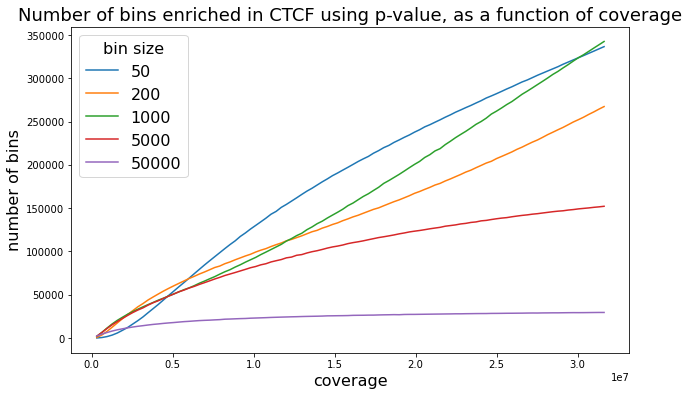

In [30]:
bins_list = list(CTCF_enrichments_pval.index.levels[0])
div_list = list(CTCF_enrichments_pval.index.levels[1])
plt.figure(figsize=(10, 6))
for b in bins_list:
    plt.plot(CTCF_enrichments_pval.loc[b, 'total_cov'], CTCF_enrichments_pval.loc[b, 'IP'], label=b)
plt.legend(fontsize=16, title='bin size', title_fontsize=16)
plt.title('Number of bins enriched in CTCF using p-value, as a function of coverage', fontsize=18)
plt.xlabel('coverage', fontsize=16)
plt.ylabel('number of bins', fontsize=16)
# plt.yscale('log')
plt.show()
plt.close()

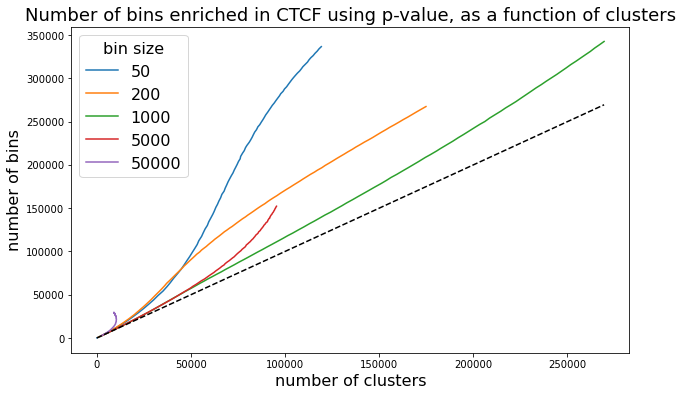

In [31]:
bins_list = list(CTCF_enrichments_pval.index.levels[0])
div_list = list(CTCF_enrichments_pval.index.levels[1])
plt.figure(figsize=(10, 6))
for b in bins_list:
    plt.plot(CTCF_enrichments_pval.loc[b, 'IP_clust'], CTCF_enrichments_pval.loc[b, 'IP'], label=b)
max_clust = np.max(CTCF_enrichments_pval['IP_clust'])
plt.plot([0, max_clust], [0, max_clust], color='black', linestyle='--')
plt.legend(fontsize=16, title='bin size', title_fontsize=16)
plt.title('Number of bins enriched in CTCF using p-value, as a function of clusters', fontsize=18)
plt.xlabel('number of clusters', fontsize=16)
plt.ylabel('number of bins', fontsize=16)
# plt.yscale('log')
plt.show()
plt.close()

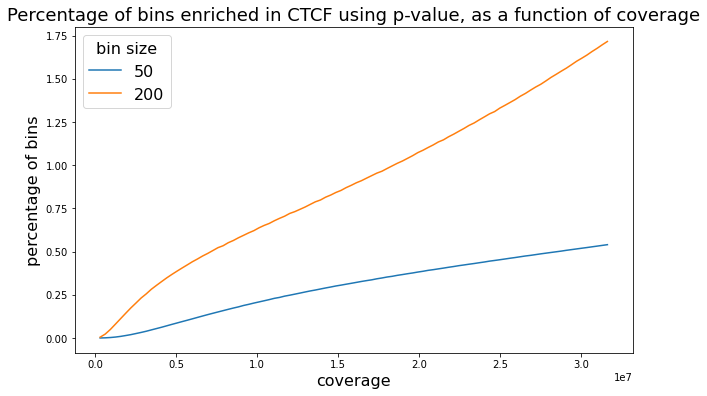

In [28]:
bins_list = list(CTCF_enrichments_pval.index.levels[0])
div_list = list(CTCF_enrichments_pval.index.levels[1])
plt.figure(figsize=(10, 6))
for b in bins_list[:2]:
    plt.plot(CTCF_enrichments_pval.loc[b, 'total_cov'], CTCF_enrichments_pval.loc[b, 'IP_perc'], label=b)
plt.legend(fontsize=16, title='bin size', title_fontsize=16)
plt.title('Percentage of bins enriched in CTCF using p-value, as a function of coverage', fontsize=18)
plt.xlabel('coverage', fontsize=16)
plt.ylabel('percentage of bins', fontsize=16)
# plt.yscale('log')
plt.show()
plt.close()

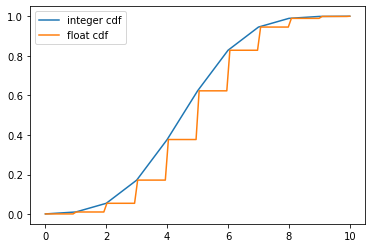

In [105]:
res_int = scipy.stats.binom.cdf(np.linspace(0, 10, 11), 10, 0.5)
res_nonint = scipy.stats.binom.cdf(np.linspace(0, 10, 100), 10, 0.5)
plt.plot(np.linspace(0, 10, 11), res_int, label='integer cdf')
plt.plot(np.linspace(0, 10, 100), res_nonint, label='float cdf')
plt.legend()
plt.show()
plt.close()

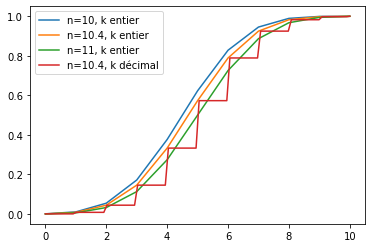

In [115]:
res_int = scipy.stats.binom.cdf(np.linspace(0, 10, 11), 10, 0.5)
res_nonint = scipy.stats.binom.cdf(np.linspace(0, 10, 11), 10.4, 0.5)
res_int2 = scipy.stats.binom.cdf(np.linspace(0, 10, 11), 11, 0.5)
res_nonint2 = scipy.stats.binom.cdf(np.linspace(0, 10, 100), 10.4, 0.5)
plt.plot(np.linspace(0, 10, 11), res_int, label='n=10, k entier')
plt.plot(np.linspace(0, 10, 11), res_nonint, label='n=10.4, k entier')
plt.plot(np.linspace(0, 10, 11), res_int2, label='n=11, k entier')
plt.plot(np.linspace(0, 10, 100), res_nonint2, label='n=10.4, k décimal')
plt.legend()
plt.show()
plt.close()

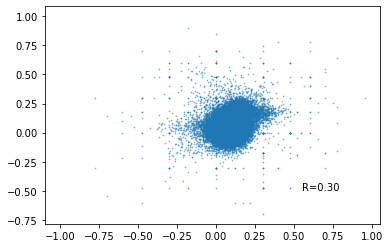

In [62]:
i = 3
Rechem_rep1 = H3K9me3_Rechem[i]['log_ratio']
Rechem_rep2 = H3K9me3_Rechem[i+4]['log_ratio']
valid_bins = np.logical_and(np.isfinite(Rechem_rep1), np.isfinite(Rechem_rep2))
corr, _ = pearsonr(Rechem_rep1[valid_bins], Rechem_rep2[valid_bins])
plt.scatter(Rechem_rep1, Rechem_rep2, s=0.5, alpha=0.5)
plt.annotate('R={0:1.2f}'.format(corr), xy = (0.7, 0.2), xycoords = 'figure fraction')
plt.plot([-1, -1], [1, 1], color='black')#, alpha=0.5)
plt.show()
plt.close()

Number of reads

In [41]:
print(np.sum(full_genome_H3K9me3['ip_binned_signal']), 'in H3K9me3')
print(np.sum(full_genome_H3K9me3['ctrl_binned_signal']), 'in INPUT-H3K9me3')
print(np.sum(full_genome_H3K4me3['ip_binned_signal']), 'in H3K4me3')
print(np.sum(full_genome_H3K4me3['ctrl_binned_signal']), 'in INPUT-H3K4me3')
data = 'H3K9me3-GSE175752'
for i, H3K9me3_Rsingle in enumerate(H3K9me3_Rechem):
    print(np.sum(H3K9me3_Rsingle['ip_binned_signal']), f' in {data}-SRR1467833{i+8}')
    print(np.sum(H3K9me3_Rsingle['ctrl_binned_signal']), f' in INPUT-{data}-SRR1467833{i+8}')

53399358.0 in H3K9me3
43781228.0 in INPUT-H3K9me3
52844132.0 in H3K4me3
44410565.0 in INPUT-H3K4me3
29657910.0  in H3K9me3-GSE175752-SRR14678338
25426870.0  in INPUT-H3K9me3-GSE175752-SRR14678338
26175159.0  in H3K9me3-GSE175752-SRR14678339
21063530.0  in INPUT-H3K9me3-GSE175752-SRR14678339
22606816.0  in H3K9me3-GSE175752-SRR146783310
25035217.0  in INPUT-H3K9me3-GSE175752-SRR146783310
28199410.0  in H3K9me3-GSE175752-SRR146783311
21901600.0  in INPUT-H3K9me3-GSE175752-SRR146783311
26626674.0  in H3K9me3-GSE175752-SRR146783312
27302126.0  in INPUT-H3K9me3-GSE175752-SRR146783312
34406481.0  in H3K9me3-GSE175752-SRR146783313
32337947.0  in INPUT-H3K9me3-GSE175752-SRR146783313
23176481.0  in H3K9me3-GSE175752-SRR146783314
30195088.0  in INPUT-H3K9me3-GSE175752-SRR146783314
44731176.0  in H3K9me3-GSE175752-SRR146783315
34051616.0  in INPUT-H3K9me3-GSE175752-SRR146783315


In [110]:
df_Rechem_pooled = pool_experiments(H3K9me3_Rechem)
print(np.sum(df_Rechem_pooled['ip_binned_signal']), 'in H3K9me3')
df_Rechem_pooled

13564/62359 significantly enriched bins in H3K9me3-GSE175752
235580107.0 in H3K9me3


,pos,ip_binned_signal,ctrl_binned_signal,binom_p_value_complete,binom_q_value_complete,-log(qvalue_complete),-log(pvalue_complete),significantly_enriched
0,0.0,5264.0,5380.0,1.000000,1.000000,-0.000000,2.556282e-08,False
1,50000.0,3778.0,3481.0,0.484929,1.000000,-0.000000,3.143217e-01,False
2,100000.0,3203.0,3077.0,0.947372,1.000000,-0.000000,2.347965e-02,False
3,150000.0,2581.0,2510.0,0.971139,1.000000,-0.000000,1.271843e-02,False
4,200000.0,2484.0,2498.0,0.998896,1.000000,-0.000000,4.799255e-04,False
...,...,...,...,...,...,...,...,...
62354,62250000.0,3157.0,2844.0,0.183022,0.622957,0.205542,7.374958e-01,False
62355,62300000.0,3039.0,2712.0,0.107245,0.392470,0.406193,9.696229e-01,False
62356,62350000.0,3361.0,2952.0,0.026644,0.113051,0.946725,1.574395e+00,False
62357,62400000.0,3025.0,2860.0,0.830714,1.000000,-0.000000,8.054829e-02,False


In [13]:
ctrl_vs_ctrl1 = enrichment_analysis(full_genome_H3K9me3['ctrl_binned_signal'], full_genome_H3K4me3['ctrl_binned_signal'])
ctrl_vs_ctrl2 = enrichment_analysis(full_genome_H3K4me3['ctrl_binned_signal'], full_genome_H3K9me3['ctrl_binned_signal'])
ctrl_vs_ctrl1

3/62359 significantly enriched bins in signal
0/62359 significantly enriched bins in signal


,binom_p_value_complete,binom_q_value_complete,-log(pvalue_complete),-log(qvalue_complete),significantly_enriched
0,0.597503,1.000000,0.223660,-0.000000,False
1,0.623964,1.000000,0.204840,-0.000000,False
2,0.312429,0.979969,0.505248,0.008788,False
3,0.023174,0.641879,1.634996,0.192547,False
4,0.814831,1.000000,0.088932,-0.000000,False
...,...,...,...,...,...
62354,0.940501,1.000000,0.026641,-0.000000,False
62355,0.447473,1.000000,0.349233,-0.000000,False
62356,0.352458,0.999764,0.452893,0.000103,False
62357,0.503150,1.000000,0.298303,-0.000000,False


In [259]:
def fdr_bh(p):
    q = np.copy(p)
    # sort
    order = np.argsort(q)
    q = q[order]
    # compute p_value correction
    q = np.minimum(q*len(q)/np.arange(1, len(q)+1), 1)
    # preserve order by taking min of upper values
    q[::-1] = np.minimum.accumulate(q[::-1])
    # unsort before output
    return q[np.argsort(order)]

my_q_value_H3K9me3 = fdr_bh(full_genome_H3K9me3['binom_p_value_complete'])
my_q_value_H3K4me3 = fdr_bh(full_genome_H3K4me3['binom_p_value_complete'])

assert np.allclose(my_q_value_H3K9me3, full_genome_H3K9me3['binom_q_value_complete'])
assert np.allclose(my_q_value_H3K4me3, full_genome_H3K4me3['binom_q_value_complete'])

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(full_genome_H3K4me3['binom_q_value_complete'], my_q_value_H3K4me3)
plt.xlabel("scipy's q_value implementation", fontsize=14)
plt.ylabel("my q_value implementation", fontsize=14)
# plt.xscale('log')
# plt.yscale('log')
plt.show()
plt.close()

/home/alex/anaconda3/envs/tf2.5/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


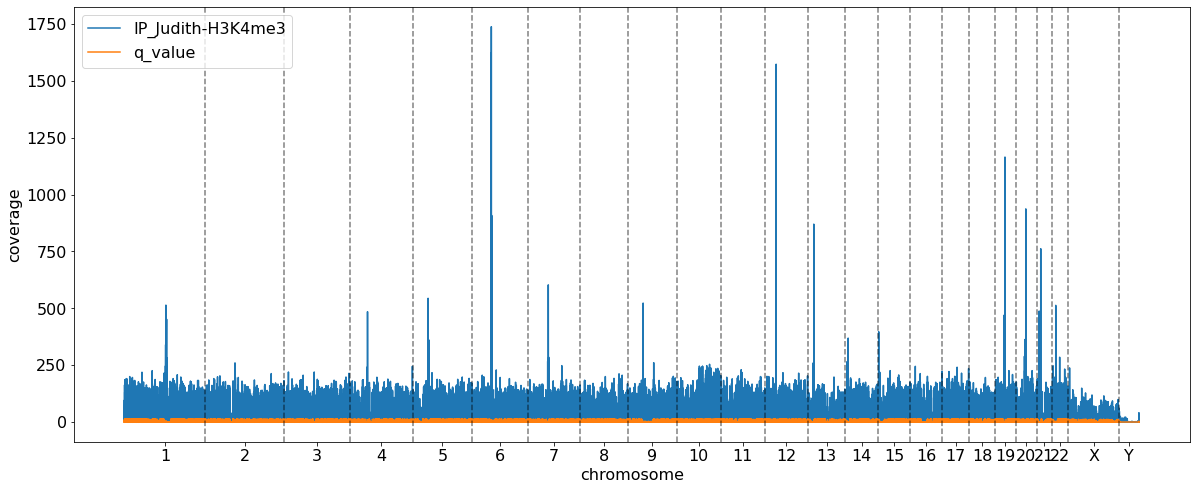

In [41]:
ax = full_genome_H3K4me3.plot(y=['ip_binned_signal', '-log(qvalue_complete)'], figsize=(20, 8), label=[f'IP_{data}', 'q_value'], fontsize=16)
for sep in seperators[:-1]:
    plt.axvline(x=sep, color='black', linestyle='--', alpha=0.5)
ax.set_xticks(utils.moving_average(np.insert(seperators, 0, 0)))
ax.set_xticklabels(chr_ids.keys())
plt.legend(fontsize=16)
plt.xlabel('chromosome', fontsize=16)
plt.ylabel('coverage', fontsize=16)
plt.show()
plt.close()

<AxesSubplot:>

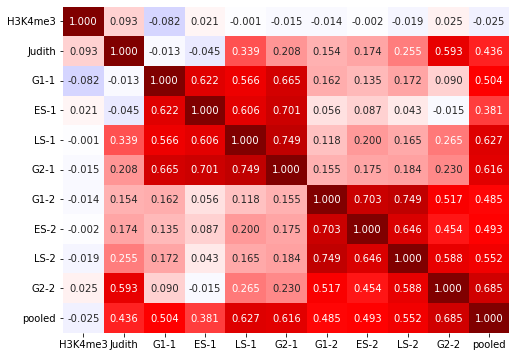

In [112]:
column = '-log(qvalue_complete)'
df_H3K9me3_compare = pd.DataFrame({'H3K4me3' : full_genome_H3K4me3[column],
                                   'Judith' : full_genome_H3K9me3[column]})
setups = np.array(['H3K4me3', 'Judith', 'G1-1', 'ES-1', 'LS-1', 'G2-1', 'G1-2', 'ES-2', 'LS-2', 'G2-2', 'pooled'])
for i in range(8):
    df_H3K9me3_compare[f'Rechem_{setups[i+1]}'] = H3K9me3_Rechem[i][column]
df_H3K9me3_compare['Rechem_pooled'] = df_Rechem_pooled[column]

corrs = np.corrcoef(df_H3K9me3_compare, rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(corrs, vmin=-1, vmax=1, annot=True, fmt='.3f',
            cmap=plt.cm.get_cmap('seismic'), cbar=False,
            xticklabels=setups, yticklabels=setups)

In [59]:
full_genome_CTCF_50.head()

,pos,ip_binned_signal,ctrl_binned_signal,log_ratio,KL,binom_p_value,binom_q_value,norm_ip_cov,norm_ctrl_cov,pvalue_divby1,qvalue_divby1,-log(qvalue_divby1),-log(pvalue_divby1),significant_divby1
0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.000000e+00,1.0,1.0,-0.0,-0.0,False
1,50.0,0.0,1.0,-inf,NaN,1.0,1.0,0.0,4.523376e-08,1.0,1.0,-0.0,-0.0,False
2,100.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.000000e+00,1.0,1.0,-0.0,-0.0,False
3,150.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.000000e+00,1.0,1.0,-0.0,-0.0,False
4,200.0,0.0,3.0,-inf,NaN,1.0,1.0,0.0,1.357013e-07,1.0,1.0,-0.0,-0.0,False


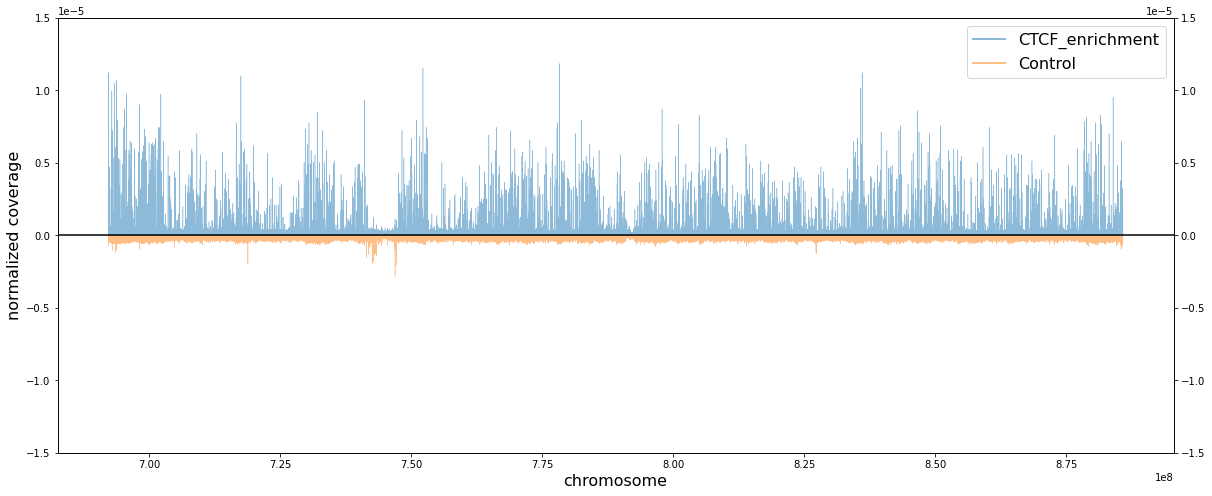

In [59]:
# H3K9me3_Rsingle = H3K9me3_Rechem[7]
start = seperators_200[2]*bins #+ 138_000_000
end = seperators_200[3]*bins #+ 152_000_000
column = "norm_ip_cov" # "-log(qvalue_divby1)" #"ip_binned_signal" "ctrl_binned_signal" "significantly_enriched"
column2 = "norm_ctrl_cov"
values_list = [full_genome_CTCF_200[column], -full_genome_CTCF_200[column2]]
label_list = ['CTCF_enrichment', 'Control']

if genome == 'T2T-CHM13v2.0':
    lengths = T2T_lengths
    chr_ids = T2T_chr_ids
elif genome == 'GRCh38':
    lengths = GRCh38_lengths
    chr_ids = hg38_chr_ids
plt.figure(figsize=(20, 8))
axes = plot_utils.compare_binned_plots(values_list, label_list, start, end, bins, alpha=0.5, linewidth=0.5)
lim = 15e-6
axes[0].set_ylim(bottom=-lim, top=lim)
axes[1].set_ylim(bottom=-lim, top=lim)
# for sep in seperators[:-1]:
#     plt.axvline(x=sep*bins, color='black', linestyle='--', alpha=0.5)
# axes[0].set_xticks(utils.moving_average(np.insert(seperators*bins, 0, 0))[:])
# axes[0].set_xticklabels(list(chr_ids.keys())[:], fontsize=16)
axes[0].set_xlabel('chromosome', fontsize=16)
axes[0].set_ylabel('normalized coverage', fontsize=16)
plt.axhline(y=0, color='black')
plt.show()
plt.close()

Autocorrelation

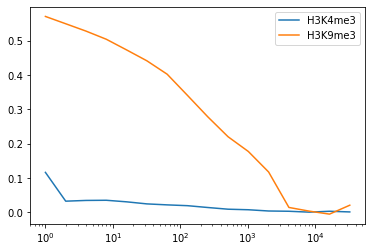

In [15]:
lags = 2**np.arange(16)
autocorrs_H3K4me3 = []
autocorrs_H3K9me3 = []
for lag in lags:
    autocorrs_H3K4me3.append(full_genome_H3K4me3['-log(qvalue_complete)'].astype(float).autocorr(lag=lag))
    autocorrs_H3K9me3.append(full_genome_H3K9me3['-log(qvalue_complete)'].astype(float).autocorr(lag=lag))
plt.plot(lags, autocorrs_H3K4me3, label='H3K4me3')
plt.plot(lags, autocorrs_H3K9me3, label='H3K9me3')
plt.xscale('log')
plt.legend()
plt.show()
plt.close()

Load npz format

In [250]:
data = 'Judith-H3K9me3'
genome = 'GRCh38'
chr_id = 1
with np.load(Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_IP_coord_all_chr.npz')) as f:
    ip_coord_chr = f[hg38_chr_ids[chr_id]]
with np.load(Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_Control_coord_all_chr.npz')) as f:
    ctrl_coord_chr = f[hg38_chr_ids[chr_id]]
# data2 = 'Judith-H3K4me3'
# with np.load(Path(data_dir, data2, 'results', f'{data2}_IP_coord_all_chr.npz')) as f:
#     ip2_coord_chr = f[hg38_chr_names[chr_id]]
# with np.load(Path(data_dir, data2, 'results', f'{data2}_Control_coord_all_chr.npz')) as f:
#     ctrl2_coord_chr = f[hg38_chr_names[chr_id]]
# data3 = 'Judith-H3K27me3'
# with np.load(Path(data_dir, data3, 'results', f'{data3}_Control_coord_all_chr.npz')) as f:
#     ctrl3_coord_chr = f[hg38_chr_names[chr_id]]
#     # for key in f.keys():
#     #     print(key)

Plot lengths

In [251]:
ip_lengths_chr = np.diff(ip_coord_chr, axis=1).ravel()
ctrl_lengths_chr = np.diff(ctrl_coord_chr, axis=1).ravel()
# ip2_lengths_chr = np.diff(ip2_coord_chr, axis=1).ravel()
# ctrl2_lengths_chr = np.diff(ctrl2_coord_chr, axis=1).ravel()
# ctrl3_lengths_chr = np.diff(ctrl3_coord_chr, axis=1).ravel()

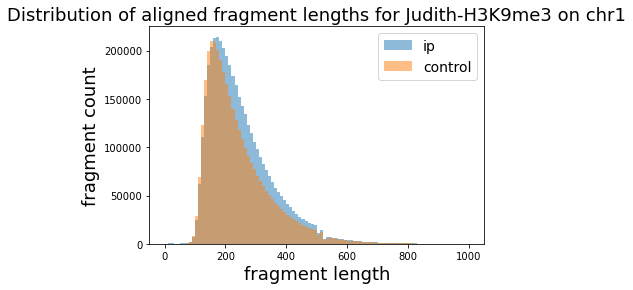

In [253]:
plt.hist(ip_lengths_chr, bins=100, range=(0, 1000), label='ip', alpha=0.5)
plt.hist(ctrl_lengths_chr, bins=100, range=(0, 1000), label='control', alpha=0.5)
# plt.hist(ip2_lengths_chr, bins=100, range=(0, 1000), label='ip2', alpha=0.5)
# plt.hist(ctrl2_lengths_chr, bins=100, range=(0, 1000), label='control2', alpha=0.5)
# plt.hist(ctrl3_lengths_chr, bins=100, range=(0, 1000), label='control3', alpha=0.5)
plt.legend(fontsize=14)
plt.title(f'Distribution of aligned fragment lengths for {data} on chr{chr_id}', fontsize=18)
plt.xlabel('fragment length', fontsize=18)
plt.ylabel('fragment count', fontsize=18)
fig_name = 
plt.savefig(f'{data_dir}/{data}/results/{data}_fragment_length_distribution_chr{chr_id}.png', bbox_inches='tight')
plt.show()
plt.close()

Filter out long fragments

In [254]:
# filter out long fragments
threshold = 1000
print(np.sum(ip_lengths_chr >= threshold), f'fragments longer than {threshold}bp in IP')
ip_coord_chr = ip_coord_chr[ip_lengths_chr <= threshold, :]
print(np.sum(ctrl_lengths_chr >= threshold), f'fragments longer than {threshold}bp in Control')
ctrl_coord_chr = ctrl_coord_chr[ctrl_lengths_chr <= threshold, :]

# print(np.sum(ip2_lengths_chr >= threshold), f'fragments longer than {threshold}bp in IP2')
# ip2_coord_chr = ip2_coord_chr[ip2_lengths_chr <= threshold, :]
# print(np.sum(ctrl2_lengths_chr >= threshold), f'fragments longer than {threshold}bp in Control2')
# ctrl2_coord_chr = ctrl2_coord_chr[ctrl2_lengths_chr <= threshold, :]

# print(np.sum(ctrl3_lengths_chr >= threshold), f'fragments longer than {threshold}bp in Control3')
# ctrl3_coord_chr = ctrl3_coord_chr[ctrl3_lengths_chr <= threshold, :]

485 fragments longer than 1000bp in IP
572 fragments longer than 1000bp in Control


#### Binned middle alignment

In [255]:
importlib.reload(utils)
bins = 1000
ip_binned_signal_chr = utils.binned_alignment_signal_from_coord(ip_coord_chr, bins=bins, length=GRCh38_lengths[f'chr{chr_id}'])
ctrl_binned_signal_chr = utils.binned_alignment_signal_from_coord(ctrl_coord_chr, bins=bins, length=GRCh38_lengths[f'chr{chr_id}'])
print(len(ip_binned_signal_chr), len(ctrl_binned_signal_chr))

# ip2_binned_signal_chr = utils.binned_alignment_signal_from_coord(ip2_coord_chr, bins=bins)
# ctrl2_binned_signal_chr = utils.binned_alignment_signal_from_coord(ctrl2_coord_chr, bins=bins)
# print(len(ip2_binned_signal_chr), len(ctrl2_binned_signal_chr))

# ctrl3_binned_signal_chr = utils.binned_alignment_signal_from_coord(ctrl3_coord_chr, bins=bins)
# print(len(ctrl3_binned_signal_chr))

248957 248957


In [294]:
log_ratio_chr = np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
KL_chr = ip_binned_signal_chr * np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)

p_binom = len(ip_coord_chr) / (len(ip_coord_chr) + len(ctrl_coord_chr))
n_binom = ip_binned_signal_chr + ctrl_binned_signal_chr
p_vals2 = 1 - scipy.stats.binom.cdf(ip_binned_signal_chr - 1, n_binom, p_binom)

/tmp/ipykernel_240455/3108555742.py:1: RuntimeWarning: divide by zero encountered in true_divide
  log_ratio_chr = np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_240455/3108555742.py:1: RuntimeWarning: invalid value encountered in true_divide
  log_ratio_chr = np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_240455/3108555742.py:1: RuntimeWarning: divide by zero encountered in log10
  log_ratio_chr = np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_240455/3108555742.py:2: RuntimeWarning: divide by zero encountered in true_divide
  KL_chr = ip_binned_signal_chr * np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_240455/3108555742.py:2: RuntimeWarning: invalid value encountered in true_divide
  KL_chr = ip_binned_signal_chr * np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_240455/3108555742.py:2: RuntimeWarning: divide by zero encountered in log10
  KL_chr = ip_binned_signal_ch

In [295]:
from statsmodels.stats import multitest
reject, q_vals, alphaS, alphaB = multitest.multipletests(p_vals, method='fdr_bh')
print(np.sum(reject), "/", len(reject), "rejected")
print(alphaS, alphaB)

202 / 248957 rejected
2.06032724991978e-07 2.0083789570086402e-07


In [246]:
df = pd.DataFrame({'pos': np.arange(0, len(ip_binned_signal_chr)*bins, bins),
                   'ip_binned_signal': ip_binned_signal_chr,
                   'ctrl_binned_signal': ctrl_binned_signal_chr,
                   'log_ratio': log_ratio_chr,
                   'KL': KL_chr,
                   'binom_p_value': p_vals,
                   'binom_q_value': q_vals})
df.to_csv(f'{data_dir}/{data}/results/alignments/{genome}/{data}_{genome}_chr{chr_id}_binned_{bins}.csv')

Plot of raw signal

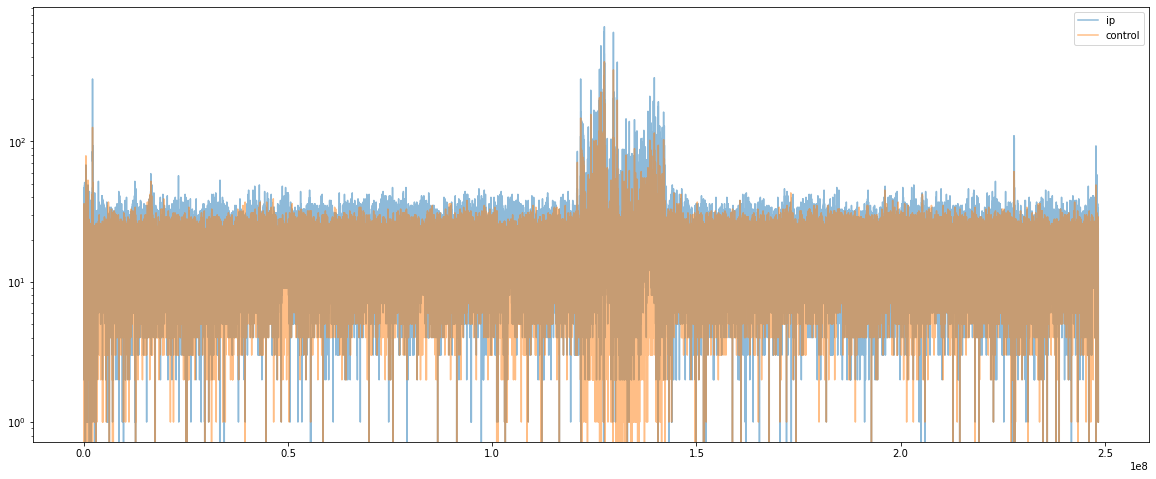

In [206]:
start = 0  # 30_000_000
end = len(ip_binned_signal_chr)*bins
bin_start = (start // bins) * bins + bins // 2
bin_end = (end // bins) * bins + bins // 2
plt.figure(figsize=(20, 8))
plt.plot(np.arange(bin_start, bin_end, bins), ip_binned_signal_chr[start//bins:end//bins], label='ip', alpha=0.5)
plt.plot(np.arange(bin_start, bin_end, bins), ctrl_binned_signal_chr[start//bins:end//bins], label='control', alpha=0.5)
# plt.plot(np.arange(bin_start, bin_end, bins), ip2_binned_signal_chr[start//bins:end//bins], label='ip2', alpha=0.5)
# plt.plot(np.arange(bin_start, bin_end, bins), ctrl2_binned_signal_chr[start//bins:end//bins], label='control2', alpha=0.5)
# plt.plot(np.arange(bin_start, bin_end, bins), ctrl3_binned_signal_chr[start//bins:end//bins], label='control3', alpha=0.5)
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

In [ ]:
# df = pd.DataFrame({'pos': np.arange(0, len(ip_binned_signal_chr)*bins, bins),
#                    'H3K9me3': ip_binned_signal_chr,
#                    'H3K4me3': ip2_binned_signal_chr,
#                    'ctrl_H3K9me3': ctrl_binned_signal_chr,
#                    'ctrl_H3K4me3': ctrl2_binned_signal_chr,
#                    'ctrl_H3K27me3': ctrl3_binned_signal_chr
#                    })
# df.to_csv(f'{data_dir}/{data3}/results/All_chr{chr_id}_binned_{bins}.csv')

In [4]:
data3 = "Judith-H3K27me3"
bins = 1000
chr_id = 1
df = pd.read_csv(f'{data_dir}/{data3}/results/All_chr{chr_id}_binned_{bins}.csv', index_col=0)

<AxesSubplot:>

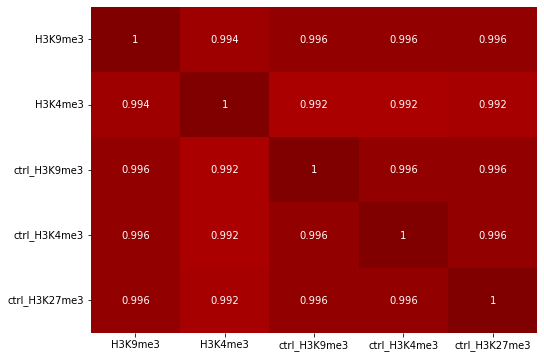

In [ ]:
corrs = np.corrcoef(df.iloc[:,1:], rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(corrs, vmin=0.9, vmax=1, annot=True, fmt='.3g',
            cmap=plt.cm.get_cmap('seismic'), cbar=False,
            xticklabels=df.columns[1:], yticklabels=df.columns[1:])

Processed signals

In [ ]:
def KL(x, y):
    return x * np.log10(x / y)

df['KL_H3K4me3_ctrl4'] = KL(df['H3K4me3'], df['ctrl_H3K4me3'])
df['KL_H3K4me3_ctrl9'] = KL(df['H3K4me3'], df['ctrl_H3K9me3'])
df['KL_H3K4me3_ctrl27'] = KL(df['H3K4me3'], df['ctrl_H3K27me3'])
df['KL_H3K9me3_ctrl4'] = KL(df['H3K9me3'], df['ctrl_H3K4me3'])
df['KL_H3K9me3_ctrl9'] = KL(df['H3K9me3'], df['ctrl_H3K9me3'])
df['KL_H3K9me3_ctrl27'] = KL(df['H3K9me3'], df['ctrl_H3K27me3'])


/home/alex/anaconda3/envs/tf2.5/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(230014, 12)
(230220, 12)


<AxesSubplot:>

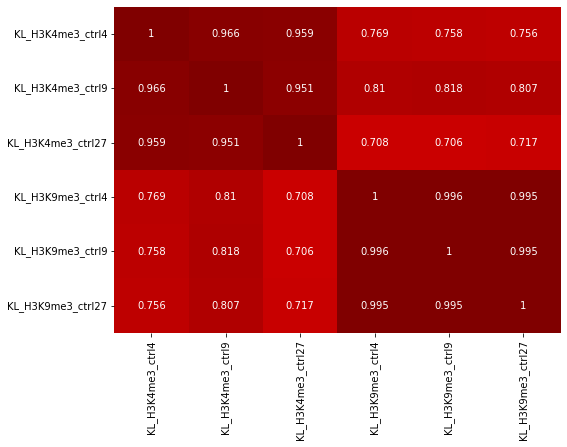

In [ ]:
df2 = df.where(np.isfinite(df)).dropna()
print(df2.shape)
print(df.shape)
corrs_processed = np.corrcoef(df2.iloc[:,6:], rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(corrs_processed, vmin=-1, vmax=1, annot=True, fmt='.3g',
            cmap=plt.cm.get_cmap('seismic'), cbar=False,
            xticklabels=df2.columns[6:], yticklabels=df2.columns[6:])

/tmp/ipykernel_240455/2711071431.py:5: RuntimeWarning: divide by zero encountered in log10
  values_list = [log_ratio_chr, KL_chr, -np.log10(p_vals)]


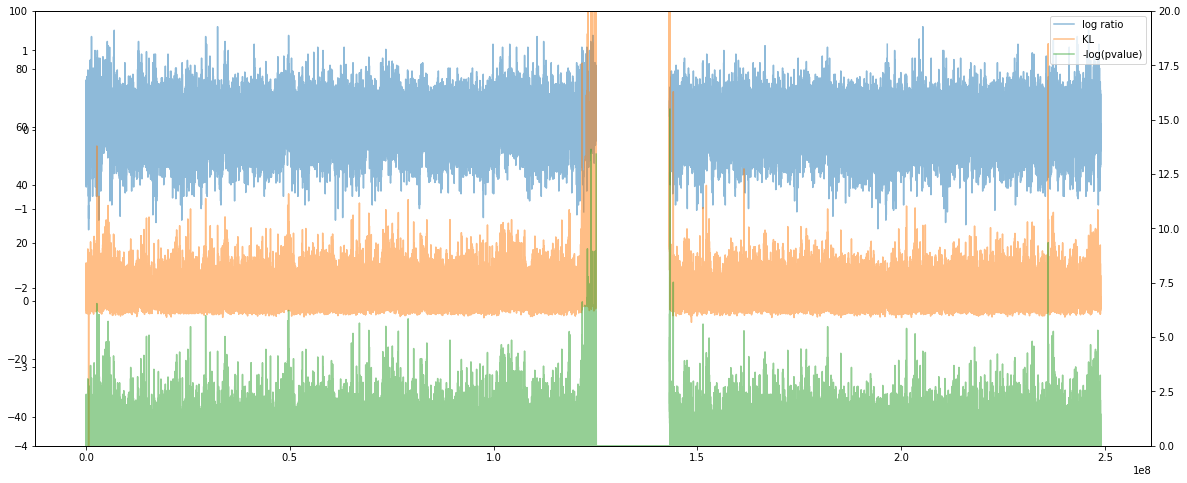

In [290]:
importlib.reload(plot_utils)
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
plt.figure(figsize=(20, 8))
values_list = [log_ratio_chr, KL_chr, -np.log10(p_vals)]
label_list = ['log ratio', 'KL', '-log(pvalue)']
axes = plot_utils.compare_binned_plots(values_list, label_list, start, end, bins, alpha=0.5)
axes[0].set_ylim(bottom=-4, top=1.5)
axes[1].set_ylim(bottom=-50, top=100)
axes[2].set_ylim(bottom=0, top=20)
plt.show()
plt.close()

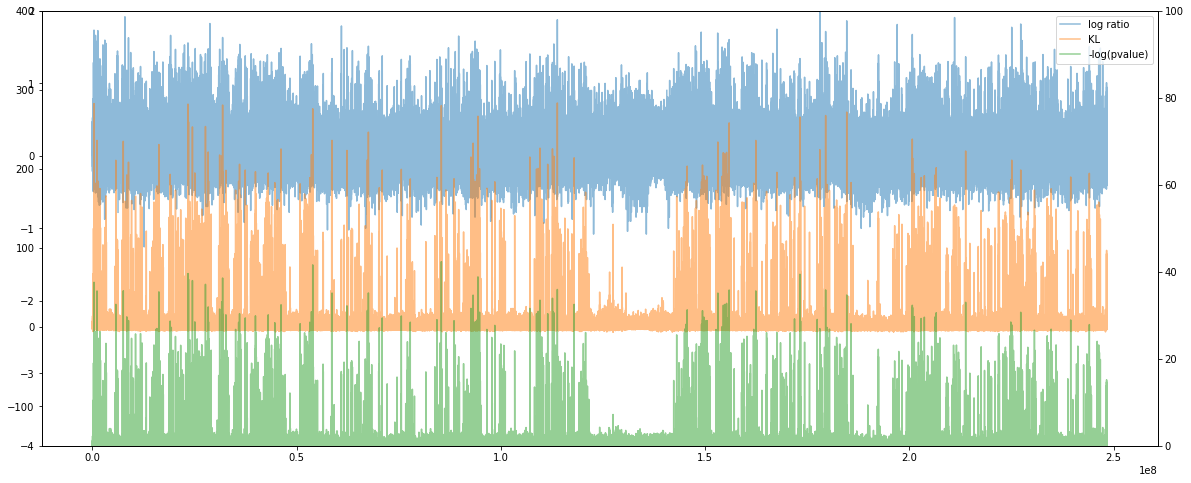

In [155]:
importlib.reload(plot_utils)
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
plt.figure(figsize=(20, 8))
values_list = [log_ratio_chr, KL_chr, -np.log10(p_vals)]
label_list = ['log ratio', 'KL', '-log(pvalue)']
axes = plot_utils.compare_binned_plots(values_list, label_list, start, end, bins, alpha=0.5)
axes[0].set_ylim(bottom=-4, top=2)
axes[1].set_ylim(bottom=-150, top=400)
axes[2].set_ylim(bottom=0, top=100)
plt.show()
plt.close()

/home/alex/anaconda3/envs/tf2.5/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


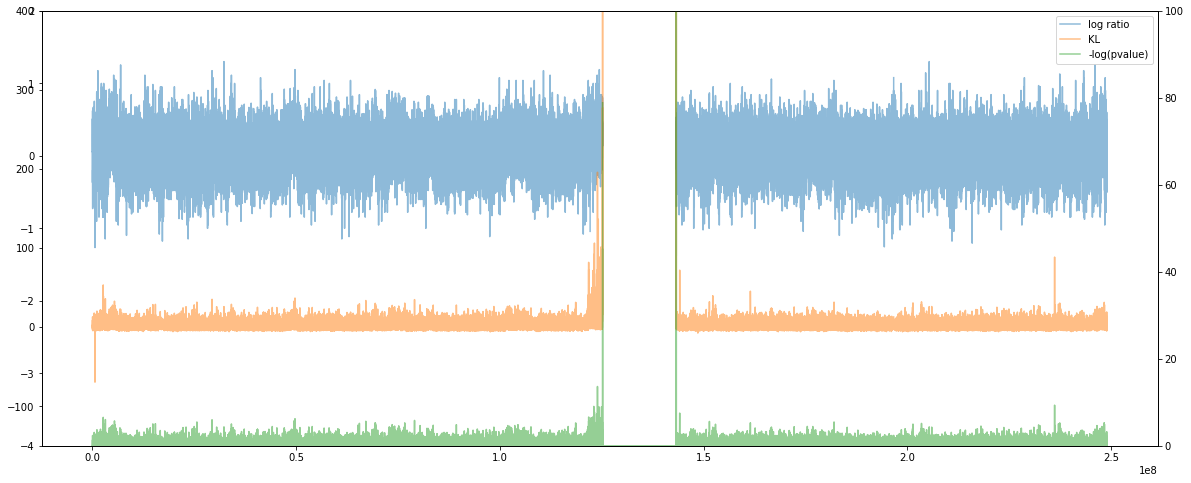

In [182]:
data = 'Judith-H3K9me3'
df = pd.read_csv(f'{data_dir}/{data}/results/alignments/GRCh38/{data}_chr{chr_id}_binned_{bins}.csv')
ip_binned_signal_chr = df['ip_binned_signal']
log_ratio_chr = df['log_ratio']
KL_chr = df['KL']
p_vals = df['binom_p_value']
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
plt.figure(figsize=(20, 8))
values_list = [log_ratio_chr, KL_chr, -np.log10(p_vals)]
label_list = ['log ratio', 'KL', '-log(pvalue)']
axes = plot_utils.compare_binned_plots(values_list, label_list, start, end, bins, alpha=0.5)
axes[0].set_ylim(bottom=-4, top=2)
axes[1].set_ylim(bottom=-150, top=400)
axes[2].set_ylim(bottom=0, top=100)
plt.show()
plt.close()

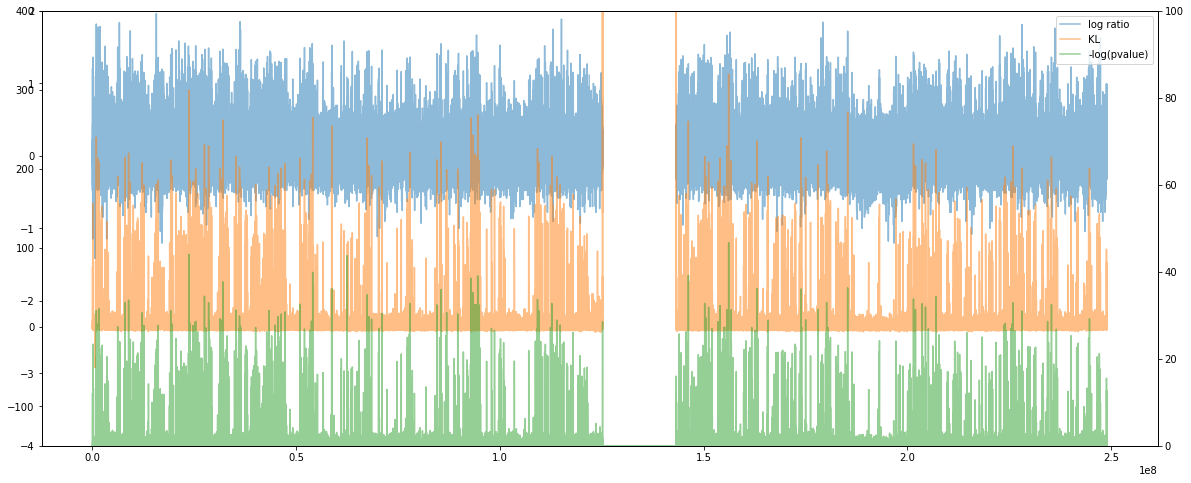

In [183]:
data = 'Judith-H3K4me3'
df = pd.read_csv(f'{data_dir}/{data}/results/alignments/GRCh38/{data}_chr{chr_id}_binned_{bins}.csv')
ip_binned_signal_chr = df['ip_binned_signal']
log_ratio_chr = df['log_ratio']
KL_chr = df['KL']
p_vals = df['binom_p_value']
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
plt.figure(figsize=(20, 8))
values_list = [log_ratio_chr, KL_chr, -np.log10(p_vals)]
label_list = ['log ratio', 'KL', '-log(pvalue)']
axes = plot_utils.compare_binned_plots(values_list, label_list, start, end, bins, alpha=0.5)
axes[0].set_ylim(bottom=-4, top=2)
axes[1].set_ylim(bottom=-150, top=400)
axes[2].set_ylim(bottom=0, top=100)
plt.show()
plt.close()

Correlation between processed signals

In [156]:
valid_bins = np.logical_and(np.isfinite(KL_chr), np.isfinite(-np.log10(p_vals)))
print(pearsonr(KL_chr[valid_bins], -np.log10(p_vals)[valid_bins]))
print(pearsonr(KL_chr[valid_bins], log_ratio_chr[valid_bins]))
print(pearsonr(-np.log10(p_vals)[valid_bins], log_ratio_chr[valid_bins]))

(0.9912833207835683, 0.0)
(0.6653103968940027, 0.0)
(0.6056913679136753, 0.0)


Plot of processed signals

/tmp/ipykernel_126826/2145195069.py:11: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(np.arange(bin_start, bin_end, bins), -np.log10(p_vals)[start//bins:end//bins], label='-log(pvalue)', alpha=0.5, color=colors[2])


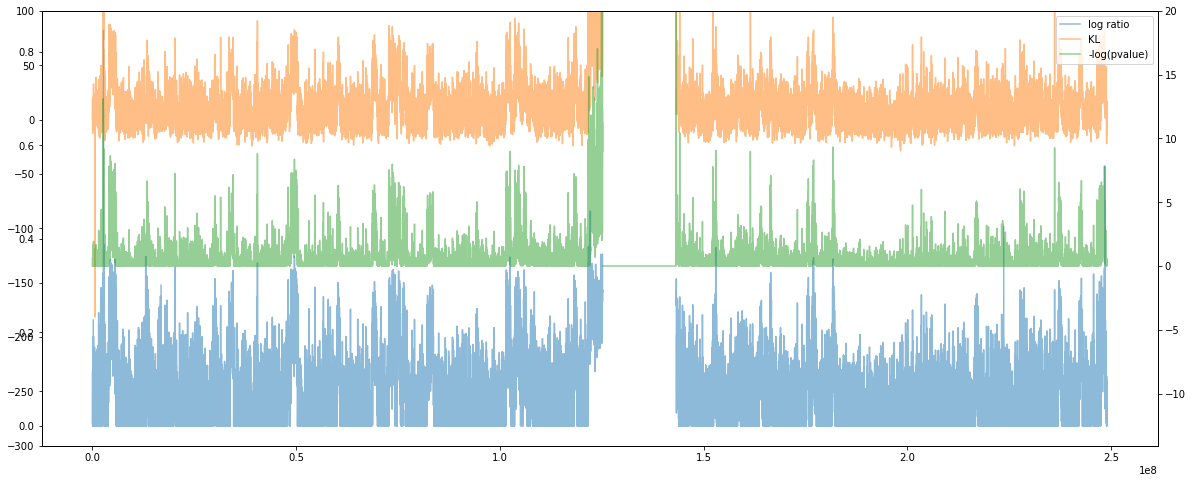

In [ ]:
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
bin_start = (start // bins) * bins + bins // 2
bin_end = (end // bins) * bins + bins // 2
plt.figure(figsize=(20, 8))
ax1 = plt.subplot()
ax1.plot(np.arange(bin_start, bin_end, bins), np.maximum(log_ratio_chr[start//bins:end//bins], 0), label='log ratio', alpha=0.5)
ax2 = ax1.twinx()
ax2.plot(np.arange(bin_start, bin_end, bins), KL_chr[start//bins:end//bins], label='KL', alpha=0.5, color=colors[1])
ax3 = ax2.twinx()
ax3.plot(np.arange(bin_start, bin_end, bins), -np.log10(p_vals)[start//bins:end//bins], label='-log(pvalue)', alpha=0.5, color=colors[2])
# ax1.set_ylim(bottom=-1.5)
ax2.set_ylim(bottom=-300, top=100)
ax3.set_ylim(top=20)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()
plt.legend(handles1 + handles2 + handles3, labels1 + labels2 + labels3)
plt.show()
plt.close()

/tmp/ipykernel_270277/2435503918.py:5: RuntimeWarning: divide by zero encountered in log
  N = np.log(ip_binned_signal_chr)
/tmp/ipykernel_270277/2435503918.py:8: RuntimeWarning: invalid value encountered in multiply
  plt.scatter(KL_chr[start//bins:end//bins], (-np.log10(p_vals)*N)[start//bins:end//bins], c=N, cmap='YlOrRd', label='positions', alpha=0.5)


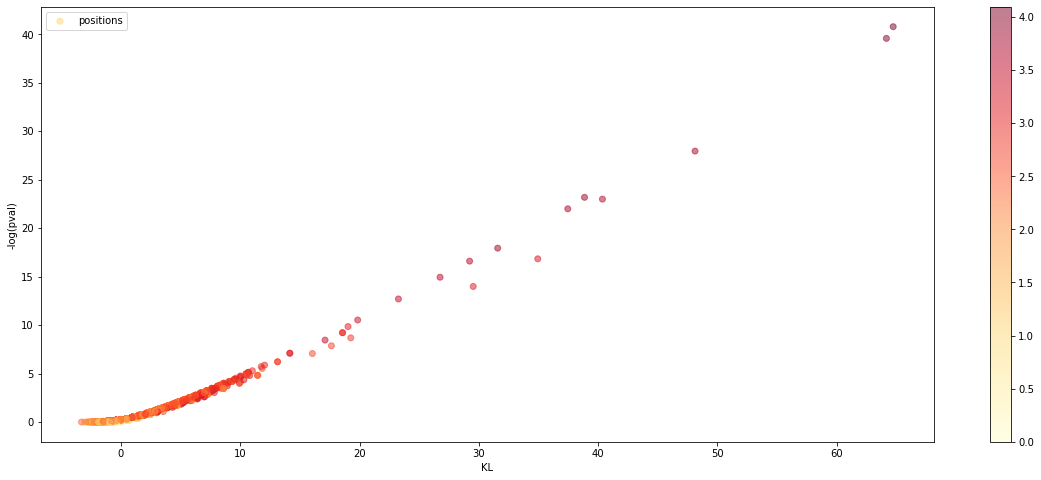

In [73]:
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
bin_start = (start // bins) * bins + bins // 2
bin_end = (end // bins) * bins + bins // 2
N = np.log(ip_binned_signal_chr)
plt.figure(figsize=(20, 8))
# ax1 = plt.subplot()
plt.scatter(KL_chr[start//bins:end//bins], (-np.log10(p_vals)*N)[start//bins:end//bins], c=N, cmap='YlOrRd', label='positions', alpha=0.5)
# plt.xlim(left=0, right=200)
# plt.ylim(bottom=0, top=15)
plt.xlabel('KL')
plt.ylabel('-log(pval)')
plt.legend()
plt.colorbar()
plt.show()
plt.close()

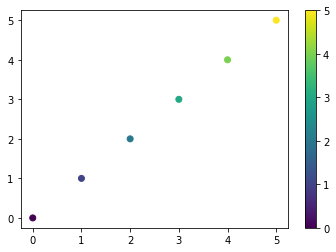

In [188]:
x = np.arange(6)
plt.scatter(x,x,c=x)
plt.colorbar()

Save to csv

In [213]:
df = pd.DataFrame({'pos': np.arange(0, len(ip_binned_signal_chr)*bins, bins),
                   'ip_binned_signal': ip_binned_signal_chr,
                   'ctrl_binned_signal': ctrl_binned_signal_chr,
                   'log_ratio': log_ratio_chr,
                   'KL': KL_chr,
                   'binom_p_value': p_vals})
df.to_csv(f'{data_dir}/{data}/results/alignments/{genome}/{data}_{genome}_chr{chr_id}_binned_{bins}.csv')

#### Exact alignment

In [ ]:
ip_signal_chr = utils.exact_alignment_signal_from_coord(ip_coord_chr)
ctrl_signal_chr = utils.exact_alignment_signal_from_coord(ctrl_coord_chr)
print(len(ip_signal_chr), len(ctrl_signal_chr))
ip_signal_chr, ctrl_signal_chr = utils.adjust_length(ip_signal_chr, ctrl_signal_chr)
print(len(ip_signal_chr), len(ctrl_signal_chr))

248946395 248946413
248946413 248946413


In [ ]:
ip_postbinned_signal_chr = convolve(ip_signal_chr, np.ones(bins) / bins, mode='same')
ctrl_postbinned_signal_chr = convolve(ctrl_signal_chr, np.ones(bins) / bins, mode='same')

In [ ]:
postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
postbinned_KL_chr = ip_postbinned_signal_chr * np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)

# p_binom = len(ip_coord_chr) / (len(ip_coord_chr) + len(ctrl_coord_chr))
# p_vals = np.zeros(len(ip_postbinned_signal_chr))
# for i in range(len(ip_postbinned_signal_chr)):
#     n_binom = ip_postbinned_signal_chr[i] + ctrl_postbinned_signal_chr[i]
#     k_binom = ip_postbinned_signal_chr[i]
#     if n_binom >= 1:
#         res = scipy.stats.binomtest(k_binom, n_binom, p=p_binom, alternative='greater')
#         p_vals[i] = res.pvalue
#     else:
#         p_vals[i] = 1

/tmp/ipykernel_122611/899252405.py:1: RuntimeWarning: divide by zero encountered in true_divide
  postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:1: RuntimeWarning: invalid value encountered in true_divide
  postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:1: RuntimeWarning: divide by zero encountered in log10
  postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:1: RuntimeWarning: invalid value encountered in log10
  postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:2: RuntimeWarning: divide by zero encountered in true_divide
  postbinned_KL_chr = ip_postbinned_signal_chr * np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:2: RuntimeWarn

In [ ]:
start = 0 # 122_000_000
end = len(ip_signal_chr)  # 40_000_000
plt.figure(figsize=(20, 8))
ax1 = plt.subplot()
ax1.plot(np.arange(start, end), ip_postbinned_signal_chr[start:end], label='ip', alpha=0.5)
repeats = utils.find_peaks_in_window(all_chr_repeats, start, end)
print(repeats.shape)
rep_height = 1
for id, (rep_start, rep_end, *_) in enumerate(repeats):
    if id == 0:
        ax1.plot([rep_start, rep_end], [rep_height, rep_height], marker = '.', color='red', label='repeats')
    else:
        ax1.plot([rep_start, rep_end], [rep_height, rep_height], marker = '.', color='red')
# plt.plot(np.arange(start, end), ctrl_signal_chr[start:end], label='control', alpha=0.5)
ax1.set_yscale('log')
# handles1, labels1 = ax1.get_legend_handles_labels()
plt.legend(loc="upper right")
plt.show()
plt.close()

(444217, 2)


: 

: 

In [100]:
ip_binned_signal_chr_old = pd.read_csv(f'{data_dir}/{data}/results/alignments/{genome}/{data}_chr{chr_id}_binned_{bins}.csv')

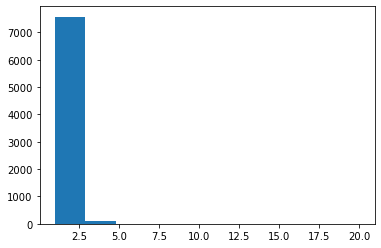

(array([7.572e+03, 8.800e+01, 9.000e+00, 4.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <BarContainer object of 10 artists>)

In [102]:
diffs = np.array(np.abs(ip_binned_signal_chr - ip_binned_signal_chr_old['ip_binned_signal']))
nonzeros, = np.nonzero(diffs)
res = plt.hist(diffs[nonzeros])
plt.show()
plt.close()
diffs[nonzeros]
res

In [ ]:
import timeit
n = 10_000_000
m = 100_000_000
coord = np.random.randint(0, m, size=2*n, dtype=int).reshape(-1, 2)
# print(coord)

In [ ]:
%%timeit
signal = utils.exact_alignment_signal_from_coord(coord)

1.33 s ± 47.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
binned_signal = utils.binned_alignment_signal_from_coord(coord, bins=1000)

794 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
binned_signal = utils.binned_alignment_signal_from_coord(coord, bins=1)

1.23 s ± 90.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
